# Group 13 - TFA Final Project

### This project explores to analyze data for Uber and Yellow Taxi rides along with weather data to produce meaningful insights and visualisations

#### Importing all dependencies required for the project as follows 

In [337]:
import pandas as pd
import requests
import re
from tqdm import tqdm
import time
import os
import glob
import math
from keplergl import KeplerGl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from bs4 import BeautifulSoup
from sqlalchemy import create_engine
import logging
import pytest

In [338]:
#Constants

URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
pattern = r"(?P<prefix>.*)(?P<tripdata>tripdata_)(?P<year>[0-9]{4})-(?P<month>[0-9]{2})(?P<rest>.*)"

newark_box=[-74.205780,40.661560,-74.146042,40.711833]
laguardia_box=[-73.901854,40.754908,-73.847694,40.789443]
jfk_box=[-73.839455,40.618057,-73.736458,40.679565]

#### This line below generates a requirement.txt file with all the dependencies of the project

In [321]:
!pip3 freeze > requirements.txt

# Part 1: Data Preprocessing

### Here we are trying to download all of the yellow taxi data from the URL provided. We will be using beautiful soup to scrape all the links for all yellow taxi ride data on the website and we will be further using regular expression to filter only the files which we need for the analysis between 2009 and mid of 2015.

In [152]:
r = requests.get(URL)
soup = BeautifulSoup(r.content, 'html5lib') 

In [153]:
soup = BeautifulSoup(r.content)
table = soup.find_all('a',title="Yellow Taxi Trip Records")

In [155]:
links=[]
for row in table:
    match = re.search(r'href=[\'"]?([^\'" >]+)', str(row))
    if match:
        links.append(str(match.group(1)))

In [157]:
newlinks=[]
for eachlink in links:
    match=re.search(pattern,eachlink)
    year=int(match.group("year"))
    month=int(match.group("month"))
    
    if (year>=2009) and (year<2015):
        newlinks.append(eachlink)
    elif (year==2015) and (month<=6):
        newlinks.append(eachlink)

### These are the links we have successfully extracted after removing all the relevant details from each of the HTML table data elements. 

In [159]:
newlinks

['https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2015-01.csv',
 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2015-02.csv',
 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2015-03.csv',
 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2015-04.csv',
 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2015-05.csv',
 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2015-06.csv',
 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2014-01.csv',
 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2014-02.csv',
 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2014-03.csv',
 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2014-04.csv',
 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2014-05.csv',
 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2014-06.csv',
 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2014-07.csv',
 'https://s3.amazonaws.co

### This function downloads any file to our local computer with the url link provided to it in the parameter. We have had to change the chunk size for writing the file because the csv files are huge and this is necessary for improving performance.

In [10]:
def download_file(url):
    if not(os.path.exists("data")):
        os.mkdir("data")
    local_filename = url.split('/')[-1]
    local_filename="data\\"+local_filename
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                f.write(chunk)
    return local_filename

### !!!!! The following block of code calls the download function for each of the links we had extracted. Please be warned that running this takes a lot of time and it will disturb all of the other code if only run partially as this will overwrite the existing csv files.

In [59]:
# #DO NOT RUN-----------------------------------------------------------
# for i in tqdm(range(len(newlinks))):
#     eachlink=newlinks[i]
#     download_file(eachlink)

100%|████████████████████████████████████████████████████████████████████████████████| 78/78 [1:31:52<00:00, 70.67s/it]


In [144]:
path = "data"
csv_files = glob.glob(os.path.join(path, "*.csv"))

### Here we are setting the column names for our yello taxi data dataframe for better organization

In [145]:
subset=pd.read_csv("start.csv",on_bad_lines='skip')
df=pd.DataFrame()
mapping = {subset.columns[0]: 'vendor_name', 
           subset.columns[1]: 'Trip_Pickup_DateTime', 
           subset.columns[2]: 'Trip_Dropoff_DateTime', 
           subset.columns[3]: 'Passenger_Count',
           subset.columns[4]:'Trip_Distance', 
           subset.columns[5]:'Start_Lon', 
           subset.columns[6]:'Start_Lat',
           subset.columns[7]:'Rate_Code',
           subset.columns[8]:'store_and_forward',
           subset.columns[9]:'End_Lon',
           subset.columns[10]:'End_Lat',
           subset.columns[11]:'Payment_Type',
           subset.columns[12]:'Fare_Amt',
           subset.columns[13]:'surcharge',
           subset.columns[14]:'mta_tax',
           subset.columns[15]:'Tip_Amt',
           subset.columns[16]:'Tolls_Amt',
           subset.columns[17]:'Total_Amt'}

### We need to take the yellow taxi data in similar amount of rows compared to the Uber Data which has 200,000 rows. So we sample each of the monthly Yellow Taxi data to take 3000 rows from each so that the subset we have will have similar number of entries

In [29]:
masterdf=pd.DataFrame()
for i in tqdm(range(len(csv_files))):
    df = df[0:0]   
    df = pd.read_csv(csv_files[i],on_bad_lines='skip')
    subset=df.sample(n=3000)
    if len(subset.columns)>18:
        subset=subset.drop(columns=["improvement_surcharge"],errors='ignore')
    tempdf=subset
    tempdf.columns=mapping
    masterdf=masterdf.append(tempdf,ignore_index=True)
    subset.to_csv(r"sample\subset" +str(i)+ ".csv",index=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [41:19<00:00, 31.79s/it]


In [31]:
masterdf.to_csv("masterdf.csv",index=False)

In [22]:
masterdf.columns=['name', 'vendor_name', 'Trip_Pickup_DateTime',
       'Trip_Dropoff_DateTime', 'Passenger_Count', 'Trip_Distance',
       'Start_Lon', 'Start_Lat', 'Rate_Code', 'store_and_forward', 'End_Lon',
       'End_Lat', 'Payment_Type', 'Fare_Amt', 'surcharge', 'mta_tax',
       'Tip_Amt', 'Tolls_Amt']

In [23]:
masterdf.columns

Index(['name', 'vendor_name', 'Trip_Pickup_DateTime', 'Trip_Dropoff_DateTime',
       'Passenger_Count', 'Trip_Distance', 'Start_Lon', 'Start_Lat',
       'Rate_Code', 'store_and_forward', 'End_Lon', 'End_Lat', 'Payment_Type',
       'Fare_Amt', 'surcharge', 'mta_tax', 'Tip_Amt', 'Tolls_Amt'],
      dtype='object')

### We are writing this sampled yellow taxi data locally as masterdf.csv so that we dont need to open and process and sample all of the large yellow taxi data everytime we run the rest of the code

# Distance function

### Calculate distance between pickup and drop location using math module

In [368]:
def distance(series):
    
    if series.isnull().all():
        return False
    
    lat1, lon1 = float(series["Start_Lat"]),float(series["Start_Lon"])
    lat2, lon2 = float(series["End_Lat"]),float(series["End_Lon"])
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d

 ### Unit test that tests this distance calculation function. It tests whether the function breaks when it provides an empty series. Ideally it should return False

In [335]:
def test_distance():
    
    dist=distance([])
    assert dist == False

In [336]:
test_distance()

# Outside Area Trip Removal Function 

### Remove trips that start and/or end outside of the latitude/longitude coordinate box: (40.560445, -74.242330) and (40.908524, -73.717047). 

In [4]:
def outside(dataframe):
    dataframe = dataframe[ (dataframe['Start_Lat'] >= 40.560445) & (dataframe['Start_Lat'] <= 40.908524)]
    dataframe = dataframe[ (dataframe['End_Lat'] >= 40.560445) & (dataframe['End_Lat'] <= 40.908524)]
    dataframe = dataframe[ (dataframe['Start_Lon'] >= -74.242330) & (dataframe['Start_Lon'] <= -73.717047)]
    dataframe = dataframe[ (dataframe['End_Lon'] >= -74.242330) & (dataframe['End_Lon'] <= -73.717047)]
    return dataframe

# Data Cleaning

### Now we will be cleaning the yellow taxi data which we had downloaded and sampled earlier.

In [5]:
yellowdf=pd.read_csv("masterdf.csv")

C:\Users\Kunal\AppData\Local\Temp\ipykernel_14296\2527313409.py:1: DtypeWarning: Columns (0,8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  yellowdf=pd.read_csv("masterdf.csv")


In [6]:
yellowdf.head()

,vendor_name,Trip_Pickup_DateTime,Trip_Dropoff_DateTime,Passenger_Count,Trip_Distance,Start_Lon,Start_Lat,Rate_Code,store_and_forward,End_Lon,End_Lat,Payment_Type,Fare_Amt,surcharge,mta_tax,Tip_Amt,Tolls_Amt,Total_Amt
0,CMT,2009-01-13 07:54:28,2009-01-13 08:00:10,2,0.60,-73.961570,40.768545,NaN,NaN,-73.963642,40.774218,Cash,4.9,0.0,NaN,0.0,0.00,4.90
1,CMT,2009-01-22 09:02:19,2009-01-22 09:45:48,1,21.10,-73.914399,40.746171,NaN,NaN,-73.816812,40.703619,Cash,49.3,0.0,NaN,0.0,0.00,49.30
2,CMT,2009-01-23 23:52:45,2009-01-24 00:13:43,1,10.70,-73.874395,40.774010,NaN,NaN,-73.981739,40.765671,Cash,25.8,0.0,NaN,0.0,4.15,29.95
3,CMT,2009-01-06 18:34:58,2009-01-06 18:43:57,1,3.60,-73.957687,40.765477,NaN,NaN,-73.977345,40.729237,Credit,11.1,0.0,NaN,1.0,0.00,12.10
4,VTS,2009-01-02 09:52:00,2009-01-02 10:02:00,1,2.02,-74.000105,40.761962,NaN,NaN,-73.971110,40.759072,Credit,7.7,0.0,NaN,2.0,0.00,9.70


## Clean Yellow Taxi: 
### We standardize the Date column to conform to datetime format so that it is easier for manipulations
### We are now applying the distance function using the .apply() to our yellow taxi dataframe
### We will drop all the irrelevant columns we dont need for our analysis in the sql or the visualization part
### Removing Rows with very high distance and 0 distance (outliers)
### Removing trips outside latitude/longitude box using the outside function defined as earlier
### Rounding down the time to only Hour as this is the most granular data we need for further analysis

In [392]:
def clean_yellow(yellowdf):
    
    yellowdf["Date"] = yellowdf["Trip_Pickup_DateTime"].astype("datetime64")
    yellowdf["Distance"]=yellowdf.apply(distance,axis=1)
    
    yellowdf.drop(columns=["vendor_name","Passenger_Count","Rate_Code","store_and_forward","Payment_Type","Fare_Amt","surcharge","mta_tax","Tolls_Amt","Trip_Dropoff_DateTime","Trip_Distance"],errors="ignore",inplace=True)
    
    yellowdf = yellowdf[yellowdf['Distance'] <= 50]
    yellowdf = yellowdf[yellowdf['Distance'] != 0]
    
    #removing trips with 0 longitude or 0 longitude

    yellowdf = yellowdf[yellowdf['Start_Lon'] != 0]
    yellowdf = yellowdf[yellowdf['Start_Lat'] != 0]
    yellowdf = yellowdf[yellowdf['End_Lon'] != 0]
    yellowdf = yellowdf[yellowdf['End_Lat'] != 0]

    #removing trips with 0 total amount

    yellowdf = yellowdf[yellowdf['Total_Amt'] != 0]
    
    yellowdf=outside(yellowdf)
    
    yellowdf=yellowdf.assign(Date=yellowdf.Date.dt.round('H'))
    
    return yellowdf

### Calling the Clean Up Function

In [399]:
yellowdf=clean_yellow(yellowdf)
yellowdf.head()

,Trip_Pickup_DateTime,Start_Lon,Start_Lat,End_Lon,End_Lat,Tip_Amt,Total_Amt,Date,Distance,Type
0,2009-01-13 07:54:28,-73.961570,40.768545,-73.963642,40.774218,0.0,4.90,2009-01-13 08:00:00,0.654495,Yellow
1,2009-01-22 09:02:19,-73.914399,40.746171,-73.816812,40.703619,0.0,49.30,2009-01-22 09:00:00,9.487619,Yellow
2,2009-01-23 23:52:45,-73.874395,40.774010,-73.981739,40.765671,0.0,29.95,2009-01-24 00:00:00,9.087111,Yellow
3,2009-01-06 18:34:58,-73.957687,40.765477,-73.977345,40.729237,1.0,12.10,2009-01-06 19:00:00,4.356703,Yellow
4,2009-01-02 09:52:00,-74.000105,40.761962,-73.971110,40.759072,2.0,9.70,2009-01-02 10:00:00,2.463129,Yellow


In [16]:
print(yellowdf["Distance"].mean())
print(len(yellowdf))

3.344135578783831
226373


# Importing Uber Data


### We are provided this data and we need to manually download and save it our machine and then we import into a dataframe

In [402]:
uberdf=pd.read_csv("uber_rides_sample.csv")

In [403]:
uberdf.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


### Initial clean up:
###  We rename the columns to have homogenous labels with the yellow taxi data
### Dropping unnecessary columns
### Calculating the distance with latitude/longitude using the function defined as earlier

In [404]:
def initial_clean_uber(uberdf):
    
    uberdf=uberdf.drop(columns=["Unnamed: 0","passenger_count","key"],errors="ignore")

    uberdf.rename(columns = {'pickup_latitude' : 'Start_Lat', 
                             'pickup_longitude' : 'Start_Lon', 
                             'dropoff_latitude' : 'End_Lat' ,
                             'dropoff_longitude' : 'End_Lon' , 
                             'fare_amount' : 'Total_Amt',
                             'pickup_datetime' : 'Trip_Pickup_DateTime'}, 
                  inplace = True,errors="ignore")
    uberdf["Date"] = uberdf["Trip_Pickup_DateTime"].astype("datetime64")


    uberdf["Distance"]=uberdf.apply(distance,axis=1)

    return uberdf

### Calling the Clean Up Function

In [405]:
uberdf=initial_clean_uber(uberdf)

In [406]:
uberdf.head()

,Total_Amt,Trip_Pickup_DateTime,Start_Lon,Start_Lat,End_Lon,End_Lat,Date,Distance
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,2015-05-07 19:52:06,1.683323
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,2009-07-17 20:04:56,2.457590
2,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,2009-08-24 21:45:00,5.036377
3,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,2009-06-26 08:22:21,1.661683
4,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,2014-08-28 17:47:00,4.475450


<AxesSubplot:xlabel='Date'>

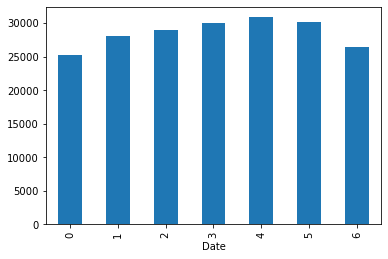

In [407]:
uberdf["Distance"].groupby(uberdf["Date"].dt.weekday).count().plot(kind="bar")

## Removing Rows with very high distance and 0 distance (outliers)

In [26]:
print(uberdf["Distance"].mean())
print(len(uberdf))

20.855349825361202
200000


In [27]:
uberdf = uberdf[uberdf['Distance'] <= 50]
uberdf = uberdf[uberdf['Distance'] != 0]

In [28]:
#removing trips with 0 longitude or 0 longitude

uberdf = uberdf[uberdf['Start_Lon'] != 0]
uberdf = uberdf[uberdf['Start_Lat'] != 0]
uberdf = uberdf[uberdf['End_Lon'] != 0]
uberdf = uberdf[uberdf['End_Lat'] != 0]

#removing trips with 0 total amount

uberdf = uberdf[uberdf['Total_Amt'] != 0]

### Removing trips outside latitude/longitude box using the outside function defined as earlier

In [29]:
uberdf=outside(uberdf)

In [30]:
print(uberdf["Distance"].mean())
print(len(uberdf))

3.33772817297078
193512


In [31]:
uberdf=uberdf.assign(Date=uberdf.Date.dt.round('H'))

# Creating dataframe combining yellow taxi and uber data

#Adding a column 'Type' to identify whether Taxi was Uber or Yellow

In [32]:

uberdf_flag=uberdf
uberdf_flag["Type"]="Uber"

yellowdf_flag=yellowdf
yellowdf_flag["Type"]="Yellow"


df_list = [uberdf_flag[['Total_Amt', 'Trip_Pickup_DateTime', 'Start_Lon', 'Start_Lat',
       'End_Lon', 'End_Lat', 'Date', 'Distance','Type']],yellowdf_flag[['Total_Amt', 'Trip_Pickup_DateTime', 'Start_Lon', 'Start_Lat',
       'End_Lon', 'End_Lat', 'Date', 'Distance','Type']]]
tdf=pd.concat(df_list, ignore_index=True)

In [33]:
tdf=tdf.assign(Date=tdf.Date.dt.round('H'))

In [34]:
tdf.sample(n=10)

,Total_Amt,Trip_Pickup_DateTime,Start_Lon,Start_Lat,End_Lon,End_Lat,Date,Distance,Type
145973,4.1,2009-09-29 22:56:52 UTC,-73.965334,40.765928,-73.960260,40.773782,2009-09-29 23:00:00,0.972253,Uber
257953,6.6,2010-11-17 15:34:00,-73.944488,40.779852,-73.959953,40.779227,2010-11-17 16:00:00,1.304005,Yellow
353329,14.4,2013-08-23 09:10:00,-73.997657,40.724267,-74.005897,40.750435,2013-08-23 09:00:00,2.991424,Yellow
155559,5.5,2014-04-17 08:34:45 UTC,-73.974430,40.765025,-73.988988,40.771046,2014-04-17 09:00:00,1.396890,Uber
18940,4.5,2014-06-17 20:13:01 UTC,-73.992747,40.737438,-73.998364,40.733756,2014-06-17 20:00:00,0.625782,Uber
274531,50.3,2011-04-16 15:36:00,-73.786008,40.641705,-73.993593,40.745705,2011-04-16 16:00:00,20.976759,Yellow
82870,10.5,2011-03-10 16:07:00 UTC,-73.977813,40.773555,-73.949808,40.785433,2011-03-10 16:00:00,2.702722,Uber
68302,10.0,2013-06-28 00:37:00 UTC,-73.944922,40.779187,-73.978970,40.789387,2013-06-28 01:00:00,3.082852,Uber
143800,11.7,2011-08-10 21:15:10 UTC,-73.983374,40.760980,-74.009091,40.724253,2011-08-10 21:00:00,4.622977,Uber
320506,41.3,2012-08-12 21:01:29,-73.870624,40.773538,-73.998020,40.756593,2012-08-12 21:00:00,10.893264,Yellow


# Weather Dataset

### We are given the weather data but we need to programatically load each and every csv file 

In [35]:
#Load all weather csv into one dataframe
path = r'weather' 
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    eachweatherdf = pd.read_csv(filename, index_col=None, header=0)
    li.append(eachweatherdf)

weatherdf = pd.concat(li, axis=0, ignore_index=True)

C:\Users\Kunal\AppData\Local\Temp\ipykernel_14296\1334377732.py:8: DtypeWarning: Columns (9,13) have mixed types. Specify dtype option on import or set low_memory=False.
  eachweatherdf = pd.read_csv(filename, index_col=None, header=0)
C:\Users\Kunal\AppData\Local\Temp\ipykernel_14296\1334377732.py:8: DtypeWarning: Columns (8,9,10,17) have mixed types. Specify dtype option on import or set low_memory=False.
  eachweatherdf = pd.read_csv(filename, index_col=None, header=0)
C:\Users\Kunal\AppData\Local\Temp\ipykernel_14296\1334377732.py:8: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  eachweatherdf = pd.read_csv(filename, index_col=None, header=0)
C:\Users\Kunal\AppData\Local\Temp\ipykernel_14296\1334377732.py:8: DtypeWarning: Columns (7,8,9,10,17,18,42,65) have mixed types. Specify dtype option on import or set low_memory=False.
  eachweatherdf = pd.read_csv(filename, index_col=None, header=0)
C:\Users\Kunal\AppData\Local\Temp\ipy

In [36]:
weatherdf["DATE"]=weatherdf["DATE"].astype("datetime64")

### Removing Dates after 2015 June

In [37]:
weatherdf = weatherdf[ (weatherdf['DATE'].dt.year < 2015) | (weatherdf['DATE'].dt.month <= 6) ]

### Creating Dataframe with daily and hourly weather data

In [38]:
dayweather=pd.DataFrame()
dayweather=weatherdf[weatherdf['HourlyDryBulbTemperature'].notna() & weatherdf['HourlyWindSpeed'].notna()]
dayweather['day'] = dayweather.DATE.dt.date
# dayweather.set_index("DATE")

C:\Users\Kunal\AppData\Local\Temp\ipykernel_14296\3935078564.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dayweather['day'] = dayweather.DATE.dt.date


In [39]:
dayweather=dayweather[["DATE","HourlyDryBulbTemperature","HourlyWindSpeed"]]
dayweather['HourlyDryBulbTemperature']=pd.to_numeric(dayweather['HourlyDryBulbTemperature'], errors='coerce')
dayweather['HourlyWindSpeed']=pd.to_numeric(dayweather['HourlyWindSpeed'], errors='coerce')
dayweather.rename(columns={"HourlyWindSpeed":"DailyAvgWindSpeed","HourlyDryBulbTemperature":"DailyTemperature"},inplace=True)

C:\Users\Kunal\AppData\Local\Temp\ipykernel_14296\1676369403.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dayweather['HourlyDryBulbTemperature']=pd.to_numeric(dayweather['HourlyDryBulbTemperature'], errors='coerce')
C:\Users\Kunal\AppData\Local\Temp\ipykernel_14296\1676369403.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dayweather['HourlyWindSpeed']=pd.to_numeric(dayweather['HourlyWindSpeed'], errors='coerce')
C:\Users\Kunal\AppData\Local\Temp\ipykernel_14296\1676369403.py:4: SettingWithCopyWa

In [40]:
dayweather.head()

,DATE,DailyTemperature,DailyAvgWindSpeed
0,2009-01-01 00:51:00,18.0,18.0
1,2009-01-01 01:51:00,18.0,18.0
2,2009-01-01 02:51:00,18.0,18.0
3,2009-01-01 03:51:00,18.0,8.0
4,2009-01-01 04:51:00,18.0,11.0


### Now we are creating a daily weather dataframe for the daily weather we will created from the use of the hourly weather data made available

In [41]:
daydf = dayweather.groupby([dayweather['DATE'].dt.date]).mean()

In [42]:
daydf.sample(10)

,DailyTemperature,DailyAvgWindSpeed
DATE,,
2010-09-10,66.166667,5.625000
2011-01-21,27.105263,7.763158
2015-02-01,31.233333,3.933333
2010-11-06,45.000000,5.291667
2013-10-25,46.727273,5.090909
2014-07-06,76.333333,4.904762
2012-02-10,39.500000,6.083333
2012-09-10,64.043478,5.130435
2014-12-09,39.826923,11.269231


### Hourly data

In [43]:
hourweather=pd.DataFrame()
hourweather=weatherdf
hourweather['day'] = hourweather.DATE.dt.date

In [44]:
hourweather=hourweather[["DATE","HourlyDryBulbTemperature","HourlyWindSpeed","HourlyPrecipitation"]]
hourweather['HourlyDryBulbTemperature']=pd.to_numeric(hourweather['HourlyDryBulbTemperature'], errors='coerce')
hourweather['HourlyWindSpeed']=pd.to_numeric(hourweather['HourlyWindSpeed'], errors='coerce')
hourweather['HourlyPrecipitation']=pd.to_numeric(hourweather['HourlyPrecipitation'], errors='coerce')
hourweather.rename(columns={"HourlyDryBulbTemperature":"HourlyTemperature"},inplace=True)

C:\Users\Kunal\AppData\Local\Temp\ipykernel_14296\127846862.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hourweather['HourlyDryBulbTemperature']=pd.to_numeric(hourweather['HourlyDryBulbTemperature'], errors='coerce')
C:\Users\Kunal\AppData\Local\Temp\ipykernel_14296\127846862.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hourweather['HourlyWindSpeed']=pd.to_numeric(hourweather['HourlyWindSpeed'], errors='coerce')
C:\Users\Kunal\AppData\Local\Temp\ipykernel_14296\127846862.py:4: SettingWithCopyW

In [45]:
hourweather.head()

,DATE,HourlyTemperature,HourlyWindSpeed,HourlyPrecipitation
0,2009-01-01 00:51:00,18.0,18.0,NaN
1,2009-01-01 01:51:00,18.0,18.0,NaN
2,2009-01-01 02:51:00,18.0,18.0,NaN
3,2009-01-01 03:51:00,18.0,8.0,NaN
4,2009-01-01 04:51:00,18.0,11.0,NaN


In [46]:
hourweather=hourweather.assign(DATE=hourweather.DATE.dt.round('H'))

In [47]:
hourdf = hourweather.groupby([hourweather['DATE']]).mean()

In [48]:
hourdf.head()

,HourlyTemperature,HourlyWindSpeed,HourlyPrecipitation
DATE,,,
2009-01-01 01:00:00,18.0,18.0,NaN
2009-01-01 02:00:00,18.0,18.0,NaN
2009-01-01 03:00:00,18.0,18.0,NaN
2009-01-01 04:00:00,18.0,8.0,NaN
2009-01-01 05:00:00,18.0,11.0,NaN


In [49]:
hourdf.sample(10)

,HourlyTemperature,HourlyWindSpeed,HourlyPrecipitation
DATE,,,
2011-09-27 03:00:00,72.0,0.000000,NaN
2014-11-05 22:00:00,57.0,0.000000,0.00
2013-01-31 20:00:00,33.0,13.000000,0.00
2013-05-24 17:00:00,49.0,8.333333,0.02
2012-08-23 05:00:00,69.0,3.000000,0.00
2010-03-07 20:00:00,54.0,8.000000,NaN
2014-03-17 09:00:00,24.0,11.000000,0.00
2014-11-09 23:00:00,48.0,0.000000,0.00
2010-05-06 06:00:00,64.0,7.000000,NaN


# Part 2 - SQL - Storing Data

In [311]:
# first create a connection - we'll create a new database 
engine = create_engine(f"sqlite:///f3.db", echo=True)
dbname="f3.db"

In [312]:
# changing the format of the log messages that sqlalchemy will
# now print out, just for easier reading;
# we also do this after we create an engine since the 
# logger doesn't exist beforehand

sqllogger = logging.getLogger("sqlalchemy.engine.Engine")
formatter = logging.Formatter("[sqlalchemy] %(message)s")
sqllogger.handlers[0].setFormatter(formatter)

In [313]:
create_uber='''CREATE TABLE IF NOT EXISTS uber (
"index" BIGINT, 
"Total_Amt" FLOAT, 
"Trip_Pickup_DateTime" TEXT, 
"Start_Lon" FLOAT, 
"Start_Lat" FLOAT, 
"End_Lon" FLOAT, 
"End_Lat" FLOAT, 
"Date" DATETIME, 
"Distance" FLOAT, 
"Type" TEXT
);

'''
create_yellow='''
CREATE TABLE IF NOT EXISTS yellow (
"index" BIGINT, 
"Trip_Pickup_DateTime" TEXT, 
"Start_Lon" FLOAT, 
"Start_Lat" FLOAT, 
"End_Lon" FLOAT, 
"End_Lat" FLOAT, 
"Tip_Amt" FLOAT,
"Total_Amt" FLOAT, 
"Date" DATETIME, 
"Distance" FLOAT, 
"Type" TEXT
);

'''

create_hour_weather='''CREATE TABLE hourtable (
"DATE" DATETIME, 
"HourlyTemperature" FLOAT, 
"HourlyWindSpeed" FLOAT, 
"HourlyPrecipitation" FLOAT
);

'''
create_day_weather='''CREATE TABLE daytable (
"DATE" DATE, 
"DailyTemperature" FLOAT, 
"DailyAvgWindSpeed" FLOAT
);

'''


create_view_sandy='''CREATE VIEW IF NOT EXISTS HurricaneSandy3 AS
    SELECT Date,
           Count( * ) Number_of_Rides
      FROM (
               SELECT Date,
                      Distance
                 FROM (
                          SELECT Date,
                                 Distance
                            FROM uber
                          UNION ALL
                          SELECT Date,
                                 Distance
                            FROM yellow
                      )
                WHERE Date >= '2012-10-21' AND 
                      Date <= '2012-11-03'
           )
     GROUP BY Date;
     
     '''

In [314]:
with open("schema.sql", "w") as f:
    f.write(create_uber)
    f.write(create_yellow)
    f.write(create_hour_weather)
    f.write(create_day_weather)
    f.write(create_view_sandy)

In [316]:
!sqlite3 $dbname < schema.sql

### We are now writing each of the dataframes we preprocessed in the earlier section to our database with the help of sql alcehmy. We have already created the tables in the database with the schema.sql file

In [ ]:
uberdf.to_sql("uber",con=engine,if_exists='append')

In [318]:
yellowdf.to_sql("yellow",con=engine,if_exists='append')

[sqlalchemy] PRAGMA main.table_info("yellow")
[sqlalchemy] [raw sql] ()
[sqlalchemy] BEGIN (implicit)
[sqlalchemy] INSERT INTO yellow ("index", "Trip_Pickup_DateTime", "Start_Lon", "Start_Lat", "End_Lon", "End_Lat", "Tip_Amt", "Total_Amt", "Date", "Distance", "Type") VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
[sqlalchemy] [generated in 3.50986s] ((0, '2009-01-13 07:54:28', -73.96156999999998, 40.768545, -73.96364199999998, 40.774218, 0.0, 4.9, '2009-01-13 08:00:00.000000', 0.654495481292893, 'Yellow'), (1, '2009-01-22 09:02:19', -73.914399, 40.746171, -73.816812, 40.703619, 0.0, 49.3, '2009-01-22 09:00:00.000000', 9.487618881241971, 'Yellow'), (2, '2009-01-23 23:52:45', -73.874395, 40.77401, -73.981739, 40.765671, 0.0, 29.95, '2009-01-24 00:00:00.000000', 9.087111076641122, 'Yellow'), (3, '2009-01-06 18:34:58', -73.957687, 40.765477, -73.977345, 40.729237, 1.0, 12.1, '2009-01-06 19:00:00.000000', 4.356703498069769, 'Yellow'), (4, '2009-01-02 09:52:00', -74.000105, 40.761962, -73.97110999

226373

In [319]:
hourdf.to_sql("hourweather",con=engine,if_exists='append')

[sqlalchemy] PRAGMA main.table_info("hourweather")
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA temp.table_info("hourweather")
[sqlalchemy] [raw sql] ()
[sqlalchemy] BEGIN (implicit)
[sqlalchemy] 
CREATE TABLE hourweather (
	"DATE" DATETIME, 
	"HourlyTemperature" FLOAT, 
	"HourlyWindSpeed" FLOAT, 
	"HourlyPrecipitation" FLOAT
)


[sqlalchemy] [no key 0.00076s] ()
[sqlalchemy] CREATE INDEX "ix_hourweather_DATE" ON hourweather ("DATE")
[sqlalchemy] [no key 0.00091s] ()
[sqlalchemy] COMMIT
[sqlalchemy] BEGIN (implicit)
[sqlalchemy] INSERT INTO hourweather ("DATE", "HourlyTemperature", "HourlyWindSpeed", "HourlyPrecipitation") VALUES (?, ?, ?, ?)
[sqlalchemy] [generated in 0.45984s] (('2009-01-01 01:00:00.000000', 18.0, 18.0, None), ('2009-01-01 02:00:00.000000', 18.0, 18.0, None), ('2009-01-01 03:00:00.000000', 18.0, 18.0, None), ('2009-01-01 04:00:00.000000', 18.0, 8.0, None), ('2009-01-01 05:00:00.000000', 18.0, 11.0, None), ('2009-01-01 06:00:00.000000', 16.0, 18.0, None), ('2009-01-0

56048

In [320]:
daydf.to_sql("dayweather",con=engine,if_exists='append')

[sqlalchemy] PRAGMA main.table_info("dayweather")
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA temp.table_info("dayweather")
[sqlalchemy] [raw sql] ()
[sqlalchemy] BEGIN (implicit)
[sqlalchemy] 
CREATE TABLE dayweather (
	"DATE" DATE, 
	"DailyTemperature" FLOAT, 
	"DailyAvgWindSpeed" FLOAT
)


[sqlalchemy] [no key 0.00071s] ()
[sqlalchemy] CREATE INDEX "ix_dayweather_DATE" ON dayweather ("DATE")
[sqlalchemy] [no key 0.00089s] ()
[sqlalchemy] COMMIT
[sqlalchemy] BEGIN (implicit)
[sqlalchemy] INSERT INTO dayweather ("DATE", "DailyTemperature", "DailyAvgWindSpeed") VALUES (?, ?, ?)
[sqlalchemy] [generated in 0.01561s] (('2009-01-01', 20.75, 11.041666666666666), ('2009-01-02', 31.322580645161292, 6.806451612903226), ('2009-01-03', 32.833333333333336, 9.875), ('2009-01-04', 33.888888888888886, 7.37037037037037), ('2009-01-05', 41.2962962962963, 6.925925925925926), ('2009-01-06', 32.62068965517241, 7.137931034482759), ('2009-01-07', 35.68421052631579, 9.842105263157896), ('2009-01-08', 34.8

2359

# Part 3 - SQL Queries - Understanding Data

### This function executes the query and saves it in a file in the sql folder

In [271]:
def execute_and_write_query(query,name):
    
    f=open(r"sql\query_" +str(name)+ ".sql","w")
    f.write(query)
    f.close()
    
    return engine.execute(query).fetchall()

### 1.   For 01-2009 through 06-2015, what hour of the day was the most popular to take a Yellow Taxi? The result should have 24 bins.

In [275]:
query1='''
SELECT  strftime('%H', Date) hour,COUNT(*) total_yellow_rides
FROM yellow
GROUP BY hour
ORDER BY COUNT(*) DESC'''

In [276]:
execute_and_write_query(query1,"1_Most_Popular_Hour")

[sqlalchemy] 
SELECT  strftime('%H', Date) hour,COUNT(*) total_yellow_rides
FROM yellow
GROUP BY hour
ORDER BY COUNT(*) DESC
[sqlalchemy] [raw sql] ()


[('19', 14285),
 ('20', 13934),
 ('21', 12984),
 ('22', 12745),
 ('18', 12679),
 ('23', 12059),
 ('15', 11342),
 ('14', 11223),
 ('12', 11167),
 ('13', 10823),
 ('09', 10530),
 ('10', 10363),
 ('16', 10193),
 ('00', 10186),
 ('11', 10117),
 ('17', 9793),
 ('08', 9477),
 ('01', 7745),
 ('07', 6542),
 ('02', 5765),
 ('03', 4191),
 ('04', 3321),
 ('06', 2947),
 ('05', 1962)]

### 2. For the same time frame, what day of the week was the most popular to take an Uber? The result should have 7 bins.

In [282]:
query2='''
SELECT COUNT(*) Total_Uber_Rides, strftime('%w', Date) Day_of_Week
FROM uber
GROUP BY Day_of_Week
ORDER BY COUNT(*) DESC'''

In [283]:
#0-6 represent days from Sunday to Saturday
execute_and_write_query(query2,"2_Most_Popular_Day_Uber")

[sqlalchemy] 
SELECT COUNT(*) Total_Uber_Rides, strftime('%w', Date) Day_of_Week
FROM uber
GROUP BY Day_of_Week
ORDER BY COUNT(*) DESC
[sqlalchemy] [raw sql] ()


[(29759, '5'),
 (29227, '6'),
 (28923, '4'),
 (28028, '3'),
 (27133, '2'),
 (26071, '0'),
 (24371, '1')]

### 3.What is the 95% percentile of distance traveled for all hired trips during July 2013?

In [284]:
query3='''
WITH p AS (
    SELECT Distance,
           NTILE(100) OVER (ORDER BY Distance) AS percentile_bucket
      FROM (
               SELECT Distance
                 FROM uber
                WHERE Date >= '2013-07' AND 
                      Date <= '2013-08'
               UNION ALL
               SELECT Distance
                 FROM yellow
                WHERE Date >= '2013-07' AND 
                      Date <= '2013-08'
           )
)
SELECT MAX(Distance) AS Distance
  FROM p
 WHERE percentile_bucket = 95;'''

In [285]:
#Dividing the data in 20 buckets with each having 5 %ile 
#The 19th bucket will correspond to 95 %ile
execute_and_write_query(query3,"3_95_Percentile")

[sqlalchemy] 
WITH p AS (
    SELECT Distance,
           NTILE(100) OVER (ORDER BY Distance) AS percentile_bucket
      FROM (
               SELECT Distance
                 FROM uber
                WHERE Date >= '2013-07' AND 
                      Date <= '2013-08'
               UNION ALL
               SELECT Distance
                 FROM yellow
                WHERE Date >= '2013-07' AND 
                      Date <= '2013-08'
           )
)
SELECT MAX(Distance) AS Distance
  FROM p
 WHERE percentile_bucket = 95;
[sqlalchemy] [raw sql] ()


[(10.21608572432051,)]

### 4.What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?

In [286]:
query4='''
Select COUNT(Distance) Rides,AVG(Distance) Average_Distance,strftime('%Y-%m-%d', Date) Date
from (SELECT Distance,Date FROM uber WHERE strftime('%Y', Date) IN('2009') UNION ALL 
SELECT Distance,Date FROM yellow WHERE strftime('%Y', Date) IN('2009')) 
GROUP BY strftime('%Y-%m-%d', Date) ORDER BY Rides DESC LIMIT 10
'''

In [288]:
execute_and_write_query(query4,"4_Average_Distance_2009")

[sqlalchemy] 
Select COUNT(Distance) Rides,AVG(Distance) Average_Distance,strftime('%Y-%m-%d', Date) Date
from (SELECT Distance,Date FROM uber WHERE strftime('%Y', Date) IN('2009') UNION ALL 
SELECT Distance,Date FROM yellow WHERE strftime('%Y', Date) IN('2009')) 
GROUP BY strftime('%Y-%m-%d', Date) ORDER BY Rides DESC LIMIT 10

[sqlalchemy] [raw sql] ()


[(259, 3.3600973680036885, '2009-12-11'),
 (232, 2.792622867915958, '2009-01-24'),
 (229, 3.0433766790373444, '2009-11-07'),
 (228, 2.6602590094018863, '2009-02-20'),
 (226, 2.459683685993068, '2009-02-12'),
 (225, 3.4167465702804254, '2009-11-06'),
 (223, 3.3236647207557257, '2009-09-12'),
 (222, 3.507321072353886, '2009-04-18'),
 (222, 2.943716124851853, '2009-01-09'),
 (221, 3.4108612558827947, '2009-07-09')]

### 5. Which 10 days in 2014 were the windiest on average, and how many hired trips were made on those days?

In [291]:
query5='''
SELECT COUNT(*) Number_of_Rides,Date as Windiest_Dates from (SELECT Distance,strftime('%Y-%m-%d', Date) Date from uber UNION ALL Select Distance,strftime('%Y-%m-%d', Date) Date from yellow) WHERE Date
IN(SELECT strftime('%Y-%m-%d', Date) Day 
from dayweather ORDER BY DailyAvgWindSpeed DESC LIMIT 10) GROUP BY Date;
'''

In [292]:
execute_and_write_query(query5,"5_Windiest_Days")

[sqlalchemy] 
SELECT COUNT(*) Number_of_Rides,Date as Windiest_Dates from (SELECT Distance,strftime('%Y-%m-%d', Date) Date from uber UNION ALL Select Distance,strftime('%Y-%m-%d', Date) Date from yellow) WHERE Date
IN(SELECT strftime('%Y-%m-%d', Date) Day 
from dayweather ORDER BY DailyAvgWindSpeed DESC LIMIT 10) GROUP BY Date;

[sqlalchemy] [raw sql] ()


[(220, '2009-04-04'),
 (198, '2009-11-13'),
 (106, '2010-02-06'),
 (254, '2010-03-13'),
 (24, '2010-12-27'),
 (237, '2011-02-19'),
 (181, '2012-02-25'),
 (44, '2012-10-29'),
 (158, '2012-12-26'),
 (195, '2013-03-06')]

### 6. During Hurricane Sandy in NYC (Oct 29-30, 2012), plus the week leading up and the week after, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed? There should be an entry for every single hour, even if no rides were taken, no precipitation was measured, or there was no wind.

- We use the VIEW HurricaneSandy3 we created earlier in the schema.sql which was as below

``` mysql
CREATE VIEW IF NOT EXISTS HurricaneSandy3 AS
    SELECT Date,
           Count( * ) Number_of_Rides
      FROM (
               SELECT Date,
                      Distance
                 FROM (
                          SELECT Date,
                                 Distance
                            FROM uber
                          UNION ALL
                          SELECT Date,
                                 Distance
                            FROM yellow
                      )
                WHERE Date >= '2012-10-21' AND 
                      Date <= '2012-11-03'
           )
     GROUP BY Date;
```

In [79]:
query6='''
SELECT strftime('%Y-%m-%d Hour %H', HurricaneSandy3.Date) Date_Hour,
       Number_of_Rides,
       hourweather.HourlyWindSpeed AS Sustained_Wind_Speed,
       hourweather.HourlyPrecipitation AS Hourly_Precipitation
  FROM HurricaneSandy3
       LEFT JOIN
       hourweather ON hourweather.DATE = HurricaneSandy3.Date;
'''

In [293]:
execute_and_write_query(query6,"6_Hurricane_Sandy")

[sqlalchemy] 
SELECT strftime('%Y-%m-%d Hour %H', HurricaneSandy3.Date) Date_Hour,
       Number_of_Rides,
       hourweather.HourlyWindSpeed AS Sustained_Wind_Speed,
       hourweather.HourlyPrecipitation AS Hourly_Precipitation
  FROM HurricaneSandy3
       LEFT JOIN
       hourweather ON hourweather.DATE = HurricaneSandy3.Date;

[sqlalchemy] [raw sql] ()


[('2012-10-21 Hour 00', 13, None, 0.0),
 ('2012-10-21 Hour 01', 17, 5.0, 0.0),
 ('2012-10-21 Hour 02', 14, 6.0, 0.0),
 ('2012-10-21 Hour 03', 7, 6.0, 0.0),
 ('2012-10-21 Hour 04', 5, 6.0, 0.0),
 ('2012-10-21 Hour 05', 2, 6.0, 0.0),
 ('2012-10-21 Hour 06', 1, 6.0, 0.0),
 ('2012-10-21 Hour 07', 3, 0.0, 0.0),
 ('2012-10-21 Hour 08', 2, 5.0, 0.0),
 ('2012-10-21 Hour 09', 4, 8.0, 0.0),
 ('2012-10-21 Hour 10', 3, 8.0, 0.0),
 ('2012-10-21 Hour 11', 13, 8.0, 0.0),
 ('2012-10-21 Hour 12', 8, 9.0, 0.0),
 ('2012-10-21 Hour 13', 10, None, 0.0),
 ('2012-10-21 Hour 14', 11, 5.0, 0.0),
 ('2012-10-21 Hour 15', 10, 9.0, 0.0),
 ('2012-10-21 Hour 16', 11, 5.0, 0.0),
 ('2012-10-21 Hour 17', 7, None, 0.0),
 ('2012-10-21 Hour 18', 11, 3.0, 0.0),
 ('2012-10-21 Hour 19', 12, 7.0, 0.0),
 ('2012-10-21 Hour 20', 10, 5.0, 0.0),
 ('2012-10-21 Hour 21', 6, 7.0, 0.0),
 ('2012-10-21 Hour 22', 5, 9.0, 0.0),
 ('2012-10-21 Hour 23', 4, 5.0, 0.0),
 ('2012-10-22 Hour 00', 4, 5.0, 0.0),
 ('2012-10-22 Hour 01', 1, 7.0, 0.0)

# Part 4: Visualizing the Data

### 1. Creating an appropriate visualization for 01-2009 through 06-2015, what hour of the day was the most popular to take a Yellow Taxi? The result should have 24 bins.

In [262]:
query1='''
SELECT  strftime('%H', Date) hour,COUNT(*) total_yellow_rides
FROM yellow
GROUP BY hour
ORDER BY COUNT(*) DESC'''

In [263]:
dfvis1=pd.read_sql(query1,con=engine)

[sqlalchemy] PRAGMA main.table_info("
SELECT  strftime('%H', Date) hour,COUNT(*) total_yellow_rides
FROM yellow
GROUP BY hour
ORDER BY COUNT(*) DESC")
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA temp.table_info("
SELECT  strftime('%H', Date) hour,COUNT(*) total_yellow_rides
FROM yellow
GROUP BY hour
ORDER BY COUNT(*) DESC")
[sqlalchemy] [raw sql] ()
[sqlalchemy] 
SELECT  strftime('%H', Date) hour,COUNT(*) total_yellow_rides
FROM yellow
GROUP BY hour
ORDER BY COUNT(*) DESC
[sqlalchemy] [raw sql] ()


In [264]:
def plot_visual_1(dfvis1):

    fig, ax = plt.subplots(figsize=(15, 10))
    hours = dfvis1["hour"]
    rides = dfvis1["total_yellow_rides"]
    ax.bar(hours,rides)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    ax.set_xlabel('Hour',fontsize=18)
    ax.set_ylabel('Number of Rides',fontsize=18)
    ax.set_title("Bar Chart showing hours of the day with most yellow taxi rides in descending order",fontsize=18)
    plt.show()

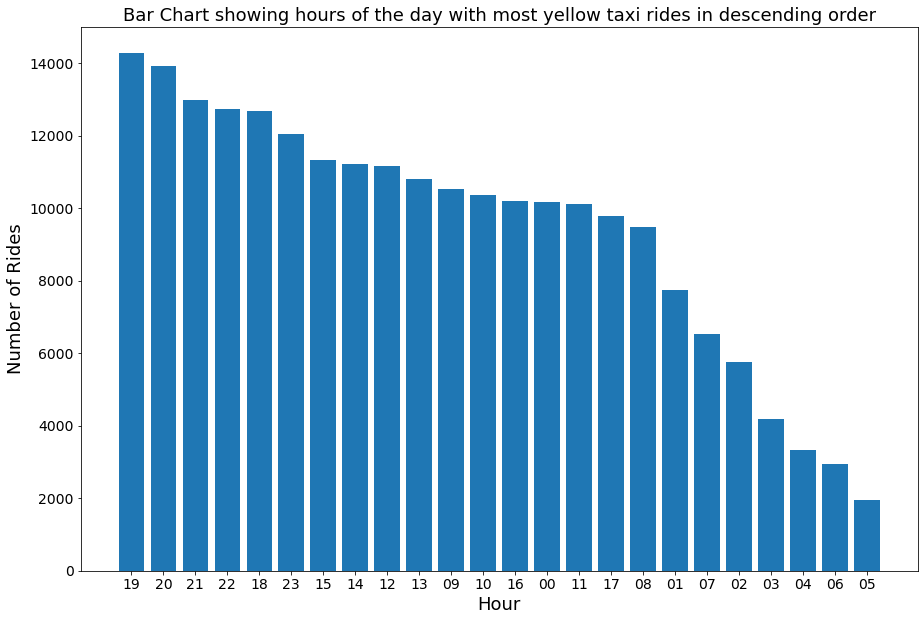

In [265]:
plot_visual_1(dfvis1)

### 2. Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month) for both taxis and Ubers combined. Include the 90% confidence interval around the mean in the visualization.


In [259]:
df_uber=pd.read_sql("Select Distance,Date from uber",con=engine)
df_yellow=pd.read_sql("Select Distance,Date from yellow",con=engine)
df_combined=df_uber.append(df_yellow)

[sqlalchemy] PRAGMA main.table_info("Select Distance,Date from uber")
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA temp.table_info("Select Distance,Date from uber")
[sqlalchemy] [raw sql] ()
[sqlalchemy] Select Distance,Date from uber
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA main.table_info("Select Distance,Date from yellow")
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA temp.table_info("Select Distance,Date from yellow")
[sqlalchemy] [raw sql] ()
[sqlalchemy] Select Distance,Date from yellow
[sqlalchemy] [raw sql] ()


C:\Users\Kunal\AppData\Local\Temp\ipykernel_14296\3810796568.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_combined=df_uber.append(df_yellow)


In [260]:
def plot_visual_2(df_combined):

    
    dfvis2=df_combined[["Distance","Date"]]

    dfvis2["Date"]=dfvis2["Date"].astype('datetime64')
    dfvis2=dfvis2[["Distance","Date"]].groupby(dfvis2.Date.dt.month).mean()

    fig, ax = plt.subplots(figsize=(15, 10))
    x = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    y = dfvis2["Distance"]
    # Define the confidence interval
    ci = 0.1 * np.std(y) / np.mean(y)
    # Plot the sinus function
    plt.plot(x, y,color='blue',label="Average Distance(mean)")
    # Plot the confidence interval
    plt.fill_between(x, (y-ci), (y+ci), color='red', alpha=0.9,label="90% Confidence Interval from the Average")

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    ax.set_xlabel('Month',fontsize=18)
    ax.set_ylabel('Average Distance',fontsize=18)
    ax.set_title("Average Distance for Each Month with 90% Confidence Interval",fontsize=18)


    plt.legend(loc="upper left",fontsize=11)


    plt.show()

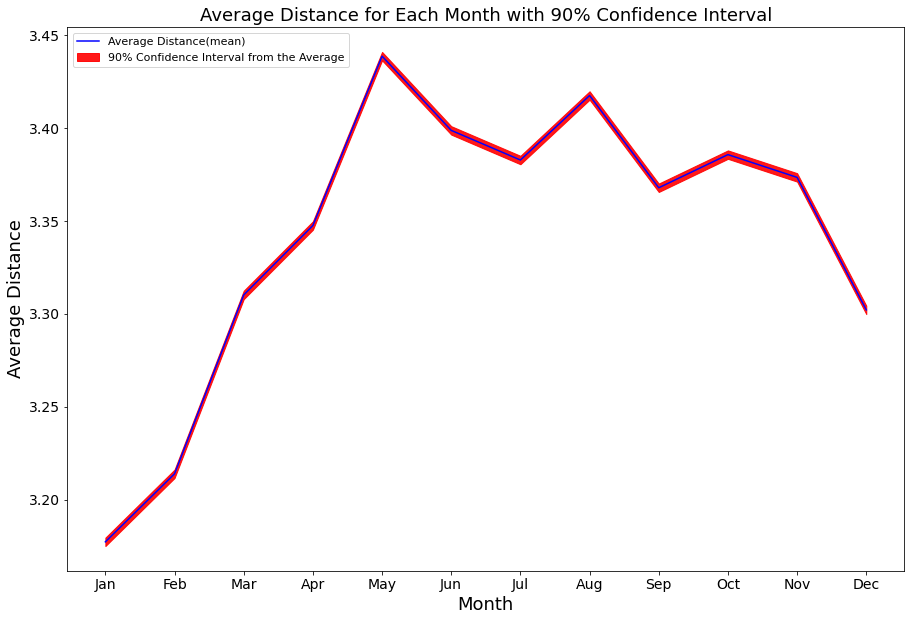

In [261]:
plot_visual_2(df_combined)

### 3. Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares what day of the week was most popular for drop offs for each airport.

In [247]:
def inside_airport(dataframe,airport_box):
    dataframe = dataframe[ (dataframe['End_Lat'] >= airport_box[1]) & (dataframe['End_Lat'] <= airport_box[3])]
    dataframe = dataframe[ (dataframe['End_Lon'] >= airport_box[0]) & (dataframe['End_Lon'] <= airport_box[2])]
    return dataframe

In [248]:
def clean_airport_data(df_airport):
    df_airport['Date']=df_airport['Date'].astype('datetime64')
    df_airport=df_airport.groupby(df_airport.Date.dt.dayofweek).count()
    df_airport["Day_Of_Week"]=df_airport.index
    df_airport["Count"]=df_airport["Date"]
    df_airport.drop(columns=["Date","Start_Lon","Start_Lat","End_Lon","End_Lat"],inplace=True)
    return df_airport   

In [249]:
df_uber=pd.read_sql("Select Date,Start_Lon,Start_Lat,End_Lon,End_Lat from uber",con=engine)
df_yellow=pd.read_sql("Select Date,Start_Lon,Start_Lat,End_Lon,End_Lat from yellow",con=engine)
df_combined=df_uber.append(df_yellow)

[sqlalchemy] PRAGMA main.table_info("Select Date,Start_Lon,Start_Lat,End_Lon,End_Lat from uber")
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA temp.table_info("Select Date,Start_Lon,Start_Lat,End_Lon,End_Lat from uber")
[sqlalchemy] [raw sql] ()
[sqlalchemy] Select Date,Start_Lon,Start_Lat,End_Lon,End_Lat from uber
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA main.table_info("Select Date,Start_Lon,Start_Lat,End_Lon,End_Lat from yellow")
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA temp.table_info("Select Date,Start_Lon,Start_Lat,End_Lon,End_Lat from yellow")
[sqlalchemy] [raw sql] ()
[sqlalchemy] Select Date,Start_Lon,Start_Lat,End_Lon,End_Lat from yellow
[sqlalchemy] [raw sql] ()


C:\Users\Kunal\AppData\Local\Temp\ipykernel_14296\575971554.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_combined=df_uber.append(df_yellow)


In [253]:
def plot_visual_3(df_combined):

    
    df_vis3_temp=df_combined
    df_newark=inside_airport(df_vis3_temp,newark_box)
    df_laguardia=inside_airport(df_vis3_temp,laguardia_box)
    df_jfk=inside_airport(df_vis3_temp,jfk_box)

    df_jfk=clean_airport_data(df_jfk)
    df_newark=clean_airport_data(df_newark)
    df_laguardia=clean_airport_data(df_laguardia)

    tags = ["Sun","Mon","Tue","Wed","Thu","Fri","Sat"]
    df = pd.DataFrame({"Newark": tuple(df_newark["Count"]), "Laguardia": tuple(df_laguardia['Count']), "JFK": tuple(df_jfk['Count'])}, index=tags)
    df.plot.bar(rot=0, figsize=(12, 5),xlabel='Day of Week', ylabel='Number of Rides', title='Daywise Number of Rides ending at each airport')
    plt.tight_layout() 
    plt.show()

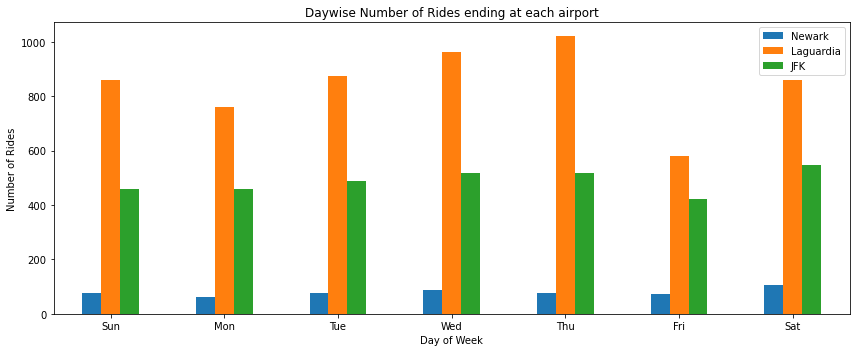

In [254]:
plot_visual_3(df_combined)

### 4. Create a heatmap of all hired trips over a map of the area. Consider using KeplerGL or another library that helps generate geospatial visualizations.


In [101]:
# !pip install keplergl
# !jupyter nbextension install --py --sys-prefix keplergl
# !jupyter nbextension enable --py --sys-prefix keplergl

In [210]:
len(df_combined)

419885

In [211]:
df_uber=pd.read_sql("Select Date,Start_Lon,Start_Lat,End_Lon,End_Lat  from uber",con=engine)
df_yellow=pd.read_sql("Select Date,Start_Lon,Start_Lat,End_Lon,End_Lat  from yellow",con=engine)
df_combined=df_uber.append(df_yellow)

[sqlalchemy] PRAGMA main.table_info("Select Date,Start_Lon,Start_Lat,End_Lon,End_Lat  from uber")
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA temp.table_info("Select Date,Start_Lon,Start_Lat,End_Lon,End_Lat  from uber")
[sqlalchemy] [raw sql] ()
[sqlalchemy] Select Date,Start_Lon,Start_Lat,End_Lon,End_Lat  from uber
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA main.table_info("Select Date,Start_Lon,Start_Lat,End_Lon,End_Lat  from yellow")
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA temp.table_info("Select Date,Start_Lon,Start_Lat,End_Lon,End_Lat  from yellow")
[sqlalchemy] [raw sql] ()
[sqlalchemy] Select Date,Start_Lon,Start_Lat,End_Lon,End_Lat  from yellow
[sqlalchemy] [raw sql] ()


C:\Users\Kunal\AppData\Local\Temp\ipykernel_14296\2269989058.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_combined=df_uber.append(df_yellow)


In [212]:
config1={'version': 'v1',
 'config': {'visState': {'filters': [],
   'layers': [{'id': '5ubthn',
     'type': 'heatmap',
     'config': {'dataId': 'New York City Taxi Trips',
      'label': 'start',
      'color': [18, 147, 154],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Start_Lat', 'lng': 'Start_Lon'},
      'isVisible': True,
      'visConfig': {'opacity': 0.8,
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radius': 10},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'weightField': None, 'weightScale': 'linear'}},
    {'id': '61sipgk',
     'type': 'point',
     'config': {'dataId': 'New York City Taxi Trips',
      'label': 'end',
      'color': [221, 178, 124],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'End_Lat', 'lng': 'End_Lon', 'altitude': None},
      'isVisible': False,
      'visConfig': {'radius': 10,
       'fixedRadius': False,
       'opacity': 0.8,
       'outline': False,
       'thickness': 2,
       'strokeColor': None,
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 50],
       'filled': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': '1qcteg',
     'type': 'arc',
     'config': {'dataId': 'New York City Taxi Trips',
      'label': 'start -> end arc',
      'color': [146, 38, 198],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat0': 'Start_Lat',
       'lng0': 'Start_Lon',
       'lat1': 'End_Lat',
       'lng1': 'End_Lon'},
      'isVisible': False,
      'visConfig': {'opacity': 0.8,
       'thickness': 2,
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'sizeRange': [0, 10],
       'targetColor': None},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': 'e57dwbw',
     'type': 'line',
     'config': {'dataId': 'New York City Taxi Trips',
      'label': 'start -> end line',
      'color': [136, 87, 44],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat0': 'Start_Lat',
       'lng0': 'Start_Lon',
       'lat1': 'End_Lat',
       'lng1': 'End_Lon',
       'alt0': None,
       'alt1': None},
      'isVisible': False,
      'visConfig': {'opacity': 0.8,
       'thickness': 2,
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'sizeRange': [0, 10],
       'targetColor': None,
       'elevationScale': 1},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}}],
   'interactionConfig': {'tooltip': {'fieldsToShow': {'New York City Taxi Trips': [{'name': 'Date',
        'format': None},
       {'name': 'Start_Lon', 'format': None},
       {'name': 'Start_Lat', 'format': None},
       {'name': 'End_Lon', 'format': None},
       {'name': 'End_Lat', 'format': None}]},
     'compareMode': False,
     'compareType': 'absolute',
     'enabled': True},
    'brush': {'size': 0.5, 'enabled': False},
    'geocoder': {'enabled': False},
    'coordinate': {'enabled': False}},
   'layerBlending': 'normal',
   'splitMaps': [],
   'animationConfig': {'currentTime': None, 'speed': 1}},
  'mapState': {'bearing': 0,
   'dragRotate': False,
   'latitude': 40.7535153683857,
   'longitude': -73.92178320729087,
   'pitch': 0,
   'zoom': 11.273086327374635,
   'isSplit': False},
  'mapStyle': {'styleType': 'dark',
   'topLayerGroups': {},
   'visibleLayerGroups': {'label': True,
    'road': True,
    'border': False,
    'building': True,
    'water': True,
    'land': True,
    '3d building': False},
   'threeDBuildingColor': [9.665468314072013,
    17.18305478057247,
    31.1442867897876],
   'mapStyles': {}}}}

In [217]:
def plot_visual_4(config1,df_combined):

    map_1 = KeplerGl(height=700,config=config1)
    dfkepler=pd.read_csv("keplertestdata.csv")
    df_combined_sub=df_combined.sample(10000)
    map_1.add_data(data=df_combined_sub,name='New York City Taxi Trips')
    return map_1

In [218]:
plot_visual_4(config1,df_combined)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '5ubthn', 'type': '…

### 5. Create a scatter plot that compares tip amount versus distance for Yellow Taxi rides. You may remove any outliers how you see fit.

In [107]:
dfvis5=pd.read_sql("Select * from yellow",con=engine)

[sqlalchemy] PRAGMA main.table_info("Select * from yellow")
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA temp.table_info("Select * from yellow")
[sqlalchemy] [raw sql] ()
[sqlalchemy] Select * from yellow
[sqlalchemy] [raw sql] ()


In [208]:
def plot_visual_5(dfvis5):


    dfvis5=dfvis5[dfvis5["Tip_Amt"]!=0]
    dfvis5=dfvis5[dfvis5["Tip_Amt"]<=15]
    dfvis5=dfvis5[dfvis5["Distance"]!=0]
    dfvis5=dfvis5[dfvis5["Distance"] <= 25]
    dfvis5=dfvis5

    dfvis5sample=dfvis5
    fig, ax = plt.subplots(figsize=(15, 10))
    x = dfvis5sample["Distance"]
    y = dfvis5sample["Tip_Amt"]

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    ax.set_xlabel('Distance(in km)',fontsize=18)
    ax.set_ylabel('Tip Amount(in USD)',fontsize=18)
    ax.set_title("Tip Amount v/s Distance",fontsize=18)


    plt.scatter(x, y)

    plt.show()

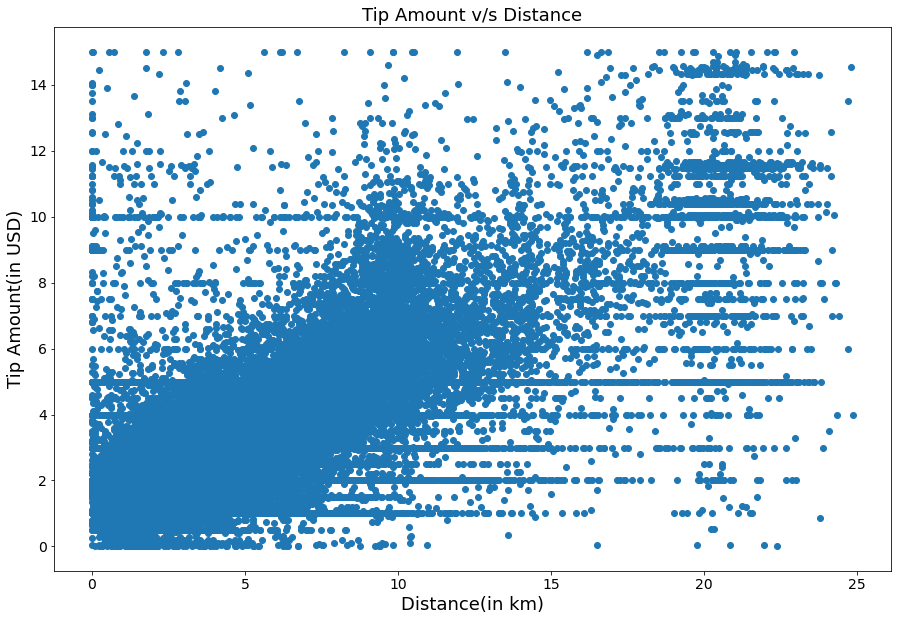

In [209]:
plot_visual_5(dfvis5)

### 6. Create another scatter plot that compares tip amount versus precipitation amount for Yellow Taxi rides. You may remove any outliers how you see fit.

In [205]:
df_yellow=pd.read_sql("Select * from yellow",con=engine)
df_hourly=pd.read_sql("Select * from hourweather",con=engine)

[sqlalchemy] PRAGMA main.table_info("Select * from yellow")
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA temp.table_info("Select * from yellow")
[sqlalchemy] [raw sql] ()
[sqlalchemy] Select * from yellow
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA main.table_info("Select * from hourweather")
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA temp.table_info("Select * from hourweather")
[sqlalchemy] [raw sql] ()
[sqlalchemy] Select * from hourweather
[sqlalchemy] [raw sql] ()


In [206]:
def plot_visual_6(df_yellow, df_hourly):

    df_yellow=df_yellow[["Date","Tip_Amt","Distance"]]
    dfvis6 = pd.merge(df_yellow, df_hourly, how='inner', left_on = 'Date', right_on = 'DATE')
    dfvis6=dfvis6[dfvis6["Tip_Amt"]!=0]
    dfvis6=dfvis6[dfvis6["HourlyPrecipitation"]!=0]
    dfvis6=dfvis6[dfvis6["HourlyPrecipitation"]<=0.5]
    dfvis6=dfvis6[dfvis6["Tip_Amt"]<=15]
    dfvis6=dfvis6[dfvis6["Distance"]!=0]
    dfvis6=dfvis6[dfvis6["Distance"] <= 25]


    dfvis6sample=dfvis6
    fig, ax = plt.subplots(figsize=(15, 10))
    x = dfvis6sample["HourlyPrecipitation"]
    y = dfvis6sample["Tip_Amt"]

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    ax.set_xlabel('HourlyPrecipitation',fontsize=18)
    ax.set_ylabel('Tip Amount',fontsize=18)
    ax.set_title("Tip Amount v/s Hourly Precipitation",fontsize=18)


    plt.scatter(x, y)

    plt.show()

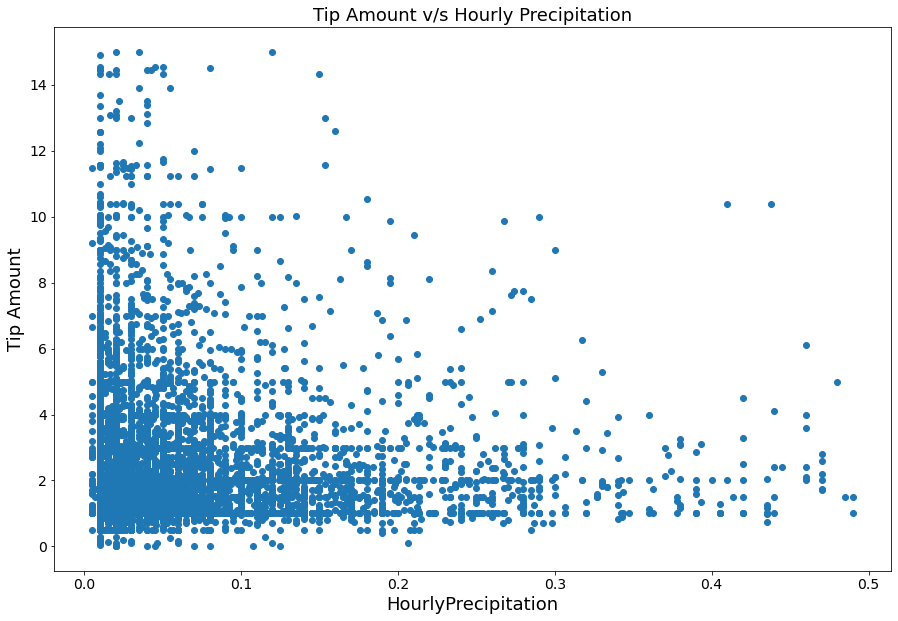

In [207]:
plot_visual_6(df_yellow, df_hourly)

### 7. Come up with 3 questions on your own that can be answered based on the data in the 4 tables. Create at least one visualization to answer each question. At least one visualization should require data from at least 3 tables.


### 7.1 Creating scatter plot that compares Total amount versus Distance for Uber Taxi rides.

In [196]:
df_uber=pd.read_sql("Select Distance,Total_Amt from uber",con=engine)

[sqlalchemy] PRAGMA main.table_info("Select Distance,Total_Amt from uber")
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA temp.table_info("Select Distance,Total_Amt from uber")
[sqlalchemy] [raw sql] ()
[sqlalchemy] Select Distance,Total_Amt from uber
[sqlalchemy] [raw sql] ()


In [198]:
def plot_visual_7_1(df_uber):
    
    df_uber=df_uber[df_uber["Total_Amt"]!=0]
    df_uber=df_uber[df_uber["Total_Amt"]>=0]
    df_uber=df_uber[df_uber["Total_Amt"]<=100]

    fig, ax = plt.subplots(figsize=(12, 10))
    x = df_uber["Distance"]
    y = df_uber["Total_Amt"]
    plt.scatter(x, y)
    plt.show()

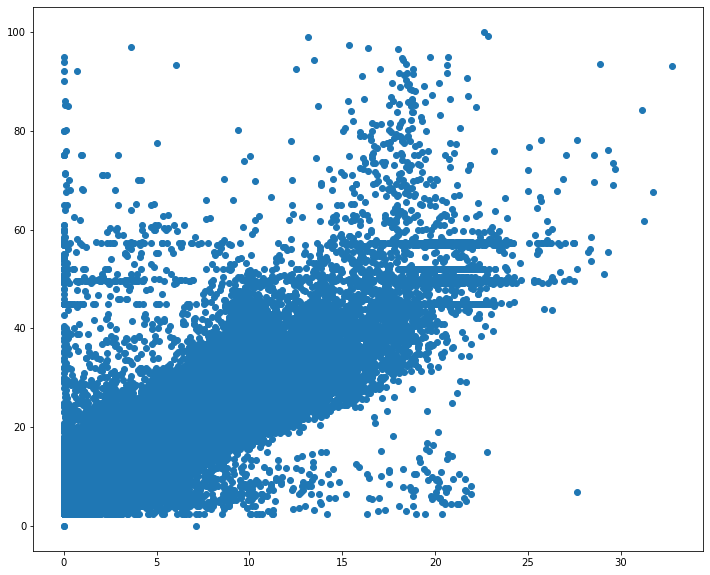

In [199]:
plot_visual_7_1(df_uber)

### 7.2 Visualize growth of average taxi fares over the years

In [187]:
df_uber=pd.read_sql("Select Date,Total_Amt from uber",con=engine)
df_yellow=pd.read_sql("Select Date,Total_Amt  from yellow",con=engine)
df_combined=df_uber.append(df_yellow)

[sqlalchemy] PRAGMA main.table_info("Select Date,Total_Amt from uber")
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA temp.table_info("Select Date,Total_Amt from uber")
[sqlalchemy] [raw sql] ()
[sqlalchemy] Select Date,Total_Amt from uber
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA main.table_info("Select Date,Total_Amt  from yellow")
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA temp.table_info("Select Date,Total_Amt  from yellow")
[sqlalchemy] [raw sql] ()
[sqlalchemy] Select Date,Total_Amt  from yellow
[sqlalchemy] [raw sql] ()


C:\Users\Kunal\AppData\Local\Temp\ipykernel_14296\2669099056.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_combined=df_uber.append(df_yellow)


In [188]:
df_combined.head()

,Date,Total_Amt
0,2015-05-07 20:00:00.000000,7.5
1,2009-07-17 20:00:00.000000,7.7
2,2009-08-24 22:00:00.000000,12.9
3,2009-06-26 08:00:00.000000,5.3
4,2014-08-28 18:00:00.000000,16.0


In [192]:
def plot_visual_7_2(df_uber, df_yellow,df_combined):

    df_uber["Date"]=df_uber["Date"].astype('datetime64')
    df_uber=df_uber[["Date","Total_Amt"]].groupby(df_uber.Date.dt.year).mean()
    df_uber["Date"]=df_uber.index    

    df_yellow["Date"]=df_yellow["Date"].astype('datetime64')
    df_yellow=df_yellow[["Date","Total_Amt"]].groupby(df_yellow.Date.dt.year).mean()
    df_yellow["Date"]=df_yellow.index

    fig, ax = plt.subplots(figsize=(12, 10))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    ax.set_xlabel('Year',fontsize=18)
    ax.set_ylabel('Average Total Amount',fontsize=18)
    ax.set_title("Average Fare of Uber and Yellow Taxi over the years",fontsize=18)
    plt.plot(df_uber["Total_Amt"],color='blue',label="Average Uber Fare",alpha=1)
    plt.plot(df_yellow["Total_Amt"],color='yellow',label="Average Yellow Taxi Fare",alpha=1)

    plt.show()

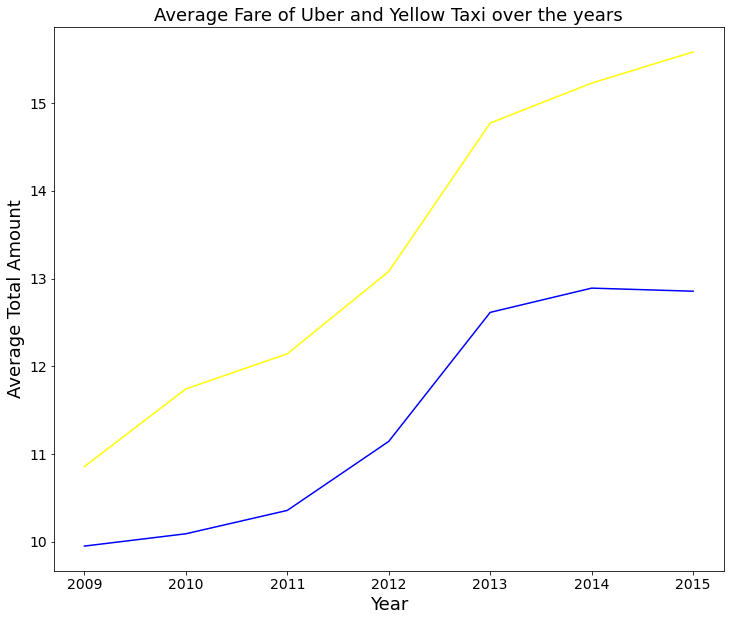

In [193]:
plot_visual_7_2(df_uber, df_yellow,df_combined)

### 7.3 Pie Chart describing Percentage of total Uber and Yellow Taxi Rides according to temperature in 30 degree increments

- This visualization uses data from 3 tables

In [186]:
df_uber=pd.read_sql("Select Date,Distance from uber",con=engine)
df_yellow=pd.read_sql("Select Date,Distance from yellow",con=engine)
df_daily=pd.read_sql("Select * from dayweather",con=engine)

df_combined=df_uber.append(df_yellow)

[sqlalchemy] PRAGMA main.table_info("Select Date,Distance from uber")
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA temp.table_info("Select Date,Distance from uber")
[sqlalchemy] [raw sql] ()
[sqlalchemy] Select Date,Distance from uber
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA main.table_info("Select Date,Distance from yellow")
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA temp.table_info("Select Date,Distance from yellow")
[sqlalchemy] [raw sql] ()
[sqlalchemy] Select Date,Distance from yellow
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA main.table_info("Select * from dayweather")
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA temp.table_info("Select * from dayweather")
[sqlalchemy] [raw sql] ()
[sqlalchemy] Select * from dayweather
[sqlalchemy] [raw sql] ()


C:\Users\Kunal\AppData\Local\Temp\ipykernel_14296\2950781132.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_combined=df_uber.append(df_yellow)


In [184]:
def plot_visual_7_3(df_daily,df_combined):

    df_combined["Date"]=df_combined["Date"].astype('datetime64')
    df_combined=df_combined[["Date","Distance"]].groupby(df_combined.Date.dt.date).count()
    df_combined["Date"]=df_combined.index
    df_combined["Date"]=df_combined["Date"].astype('datetime64')

    df_combined.reset_index(drop=True,inplace=True)
    df_daily["DATE"]=df_daily["DATE"].astype('datetime64')
    df_daily.drop(columns=["DailyAvgWindSpeed"],inplace=True)
    df_daily = pd.merge(df_daily, df_combined, how='inner', left_on = 'DATE', right_on = 'Date')    
    df_daily.rename(columns={"Distance":"Count"},inplace=True) 
    df_daily.drop(columns=["DATE"],inplace=True)    
    
    
    
    df_0to30=df_daily[(df_daily["DailyTemperature"]>=0) & (df_daily["DailyTemperature"]<=30)]
    df_30to60=df_daily[(df_daily["DailyTemperature"]>=30) & (df_daily["DailyTemperature"]<=60)]
    df_60to90=df_daily[(df_daily["DailyTemperature"]>=60) & (df_daily["DailyTemperature"]<=90)]    
    fig, ax = plt.subplots(figsize=(12, 10))
    temp = ['0 to 30 degrees', '30 to 60 degrees', '60 to 90 degrees']
    data = [len(df_0to30),len(df_30to60),len(df_60to90)]
    plt.pie(data, labels = temp,autopct='%1.2f%%',textprops={'fontsize': 18})
    plt.title("Percentage of total Uber and Yellow Taxi Rides according to temperature in 30 degree increments", fontsize=18)
    
    plt.show()

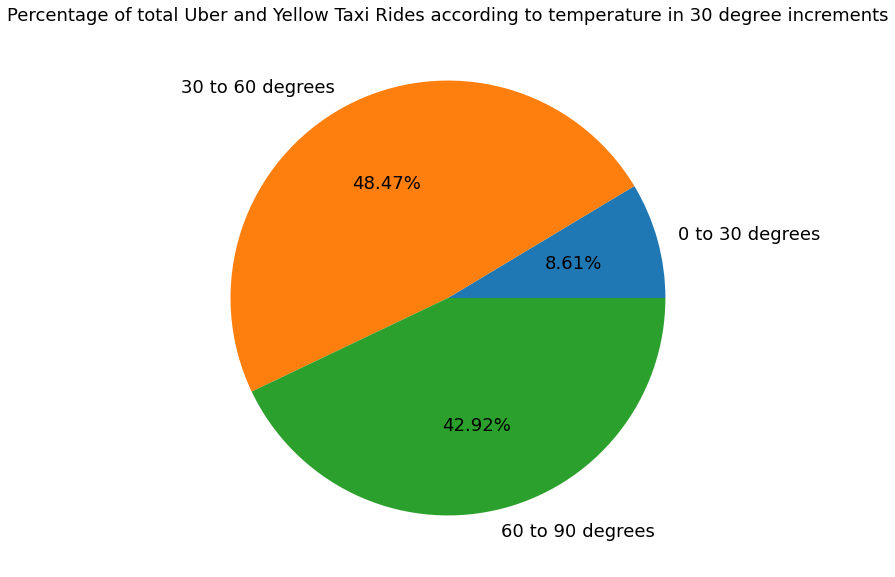

In [185]:
plot_visual_7_3(df_daily,df_combined)